# Time Series Forecasting with XGBoost / GBRT

In [1]:
from random import gauss
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
sys.path.insert(2,'..')
import functions
import xgboost as xgb
from sklearn import preprocessing
import annualized_rv as arv
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor # Random Forest model
from sklearn.ensemble import GradientBoostingRegressor # Gradient Boosting model
from sklearn.ensemble import AdaBoostRegressor # AdaBoost model
import sklearn.ensemble as ensemble

import tensorflow as tf
from tensorflow import keras

import DataProcess

In [2]:
# reads in the historic implied vol data calculated in the dailyaverageIV notebook

aaplHistIV = pd.read_pickle('historicImpliedVolData/aapl_mean_iv_2017_2022.pkl')
googHistIV = pd.read_pickle('historicImpliedVolData/goog_mean_iv_2017_2022.pkl')
msftHistIV = pd.read_pickle('historicImpliedVolData/msft_mean_iv_2017_2022.pkl')
ndxHistIV = pd.read_pickle('historicImpliedVolData/ndx_mean_iv_2017_2022.pkl')
spyHistIV = pd.read_pickle('historicImpliedVolData/spc_mean_iv_2017_2022.pkl')




In [3]:

X_train, X_test, y_train, y_test = DataProcess.preprocess_data(spyHistIV, 'SPY', seq_length=60, splits=5, window=21) #preprocess spy 
X_train_reshape = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
X_test_reshape = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])
#reshape data for xgboost
def reshape2d(X_train,X_test):
    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])
    return X_train,X_test


1 Failed download:
['SPY']: ConnectionError(MaxRetryError('HTTPSConnectionPool(host=\'fc.yahoo.com\', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000029B40A5E310>: Failed to resolve \'fc.yahoo.com\' ([Errno 11001] getaddrinfo failed)"))'))
C:\Users\Ahmed\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\Ahmed\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\Ahmed\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [5]:
def modelandeval(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    MSE,RMSE, MAE, R2 = DataProcess.evaluate_regression_metrics(y_test, y_pred)
    
    return RMSE, MAE, R2, MSE

In [32]:
#XGBoost model

model = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000)
modelandeval(model,X_train_reshape, X_test_reshape, y_train, y_test)

(0.21991062797022953,
 0.17311773731482058,
 0.47953121360780104,
 0.0483606842942607)

In [33]:
#RandomForestModel
model = ensemble.RandomForestRegressor(n_estimators=100) # reccomended forest tree size
modelandeval(model,X_train_reshape, X_test_reshape, y_train, y_test)

(0.20167229059689526,
 0.15555989431008957,
 0.5622816900213097,
 0.040671712794598566)

In [34]:
#GBRT Model
model =ensemble.GradientBoostingRegressor()
modelandeval(model,X_train_reshape, X_test_reshape, y_train, y_test)


(0.20045185612310418,
 0.15307376879904414,
 0.5675634282216453,
 0.04018094662319766)

In [35]:
#AdaBoost Model
model = ensemble.AdaBoostRegressor()
modelandeval(model,X_train_reshape, X_test_reshape, y_train, y_test)

(0.2662655971289159,
 0.21761078110714738,
 0.23698624758007736,
 0.07089736821441814)

In [36]:
#STACKING MODEL 

estimators = [
    ('rf', ensemble.RandomForestRegressor(n_estimators=100)),
    ('gbrt', ensemble.GradientBoostingRegressor()),
    ('xgb', xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000))
]

model = ensemble.StackingRegressor(estimators=estimators, final_estimator=ensemble.RandomForestRegressor(n_estimators=100))
modelandeval(model,X_train_reshape, X_test_reshape, y_train, y_test)

(0.23724663377076785,
 0.1839884397165235,
 0.3942375207345338,
 0.05628596523556084)

In [6]:
#LSTM Model
seq_length = 100

model = keras.models.Sequential([
    keras.layers.LSTM(seq_length, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    keras.layers.LSTM(seq_length),
    keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam')

# pass tensors instead of numpy arrays
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = map(lambda x: tf.convert_to_tensor(x, dtype=tf.float32), [X_train, y_train, X_test, y_test])
model.fit(X_train_tensor, y_train_tensor, epochs=50, batch_size=32)
y_pred = model.predict(X_test_tensor)
y_test_tensor = np.array(y_test_tensor)  # Ensure y_test is a numpy array for consistency

DataProcess.evaluate_regression_metrics(y_test_tensor, y_pred)
DataProcess.plot(y_test_tensor, y_pred)

C:\Users\Ahmed\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50


KeyboardInterrupt: 

# Evaluation

# Using other data

In [7]:
def preprocess_data_for_tickers(ticker_data_dict, seq_length, splits=5, window=21,reshape = True):
    X_train_reshape_list = []
    X_test_reshape_list = []
    y_train_reshape_list = []
    y_test_reshape_list = []
    
    for ticker, data in ticker_data_dict.items():
        X_train, X_test, y_train, y_test = DataProcess.preprocess_data(data, ticker, seq_length=seq_length, splits=splits, window=window)
        if reshape:
            X_train, X_test = reshape2d(X_train,X_test)
        X_train_reshape_list.append(X_train)
        X_test_reshape_list.append(X_test)
        y_train_reshape_list.append(y_train)
        y_test_reshape_list.append(y_test)
    return X_train_reshape_list, X_test_reshape_list, y_train_reshape_list, y_test_reshape_list, X_train.shape
# Example usage
ticker_data_dict = {
    'AAPL': aaplHistIV,
    'GOOG': googHistIV,
    'MSFT': msftHistIV,
    'SPY': spyHistIV
}

X_train_reshape_list, X_test_reshape_list, y_train_reshape_list, y_test_reshape_list,_ = preprocess_data_for_tickers(ticker_data_dict, seq_length=60)


In [8]:
def average_metrics(model,X_train, X_test, y_train, y_test):
    RMSE, MAE, R2,MSE = 0,0,0,0
    for X_train, X_test, y_train, y_test in zip(X_train, X_test, y_train, y_test):
        RMSE_, MAE_, R2_, MSE_ = modelandeval(model,X_train, X_test, y_train, y_test)
        RMSE += RMSE_
        MAE += MAE_
        R2 += R2_
        MSE += MSE_
    print(f'Average RMSE: {RMSE/4}')
    print(f'Average MAE: {MAE/4}')
    print(f'Average R2: {R2/4}')
    print(f'Average MSE: {MSE/4}')
    return None

In [41]:
# xgboost model
model = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000)
average_metrics(model,X_train_reshape_list, X_test_reshape_list, y_train_reshape_list, y_test_reshape_list)




Average RMSE: 0.2854948037620782
Average MAE: 0.21926092939376757
Average R2: 0.5602175248375658
Average MSE: 0.08338524382516437


In [42]:
#RandomForestModel
model = ensemble.RandomForestRegressor(n_estimators=100) # reccomended forest tree size
average_metrics(model,X_train_reshape_list, X_test_reshape_list, y_train_reshape_list, y_test_reshape_list)

Average RMSE: 0.25718795413116174
Average MAE: 0.19595120813050523
Average R2: 0.6358340741543936
Average MSE: 0.06770358975296158


In [43]:
#GBRT Model

model =ensemble.GradientBoostingRegressor()
average_metrics(model,X_train_reshape_list, X_test_reshape_list, y_train_reshape_list, y_test_reshape_list)                 

Average RMSE: 0.2637671301021554
Average MAE: 0.20111553873935972
Average R2: 0.6270559078578957
Average MSE: 0.07145403110851378


In [44]:
#Bagging Model
model = ensemble.BaggingRegressor()
average_metrics(model,X_train_reshape_list, X_test_reshape_list, y_train_reshape_list, y_test_reshape_list)

Average RMSE: 0.26724811568527584
Average MAE: 0.20615390616488843
Average R2: 0.606708811396895
Average MSE: 0.07282754831941747


In [45]:
#STACKING MODEL

estimators = [
    ('rf', ensemble.RandomForestRegressor(n_estimators=100)),
    ('gbrt', ensemble.HistGradientBoostingRegressor()),
    ('bag',ensemble.BaggingRegressor()),
    ('xgb', xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000))
]

model = ensemble.StackingRegressor(estimators=estimators, final_estimator=ensemble.RandomForestRegressor(n_estimators=100))
average_metrics(model,X_train_reshape_list, X_test_reshape_list, y_train_reshape_list, y_test_reshape_list)

Average RMSE: 0.2824828920859422
Average MAE: 0.21781168132087775
Average R2: 0.555702393373473
Average MSE: 0.08102841279469328


In [9]:
#LSTM Model
seq_length = 60

model = keras.models.Sequential([
    keras.layers.LSTM(4, return_sequences=True, input_shape=(X_train_lstm[0].shape[1], X_train_lstm[0].shape[2])),
    keras.layers.LSTM(4),
    keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam')




NameError: name 'X_train_lstm' is not defined

In [7]:
rmse, mae, r2, mse  = 0,0,0,0

for X_train, X_test, y_train, y_test in zip(X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm):
    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = map(lambda x: tf.convert_to_tensor(x, dtype=tf.float32), [X_train, y_train, X_test, y_test])
    model.fit(X_train_tensor, y_train_tensor, epochs=50, batch_size=32)
    y_pred = model.predict(X_test_tensor)
    y_test_tensor = np.array(y_test_tensor)  # Ensure y_test is a numpy array for consistency
    MSE, RMSE, MAE, R2 = DataProcess.evaluate_regression_metrics(y_test_tensor, y_pred)
    rmse += RMSE
    mae += MAE
    r2 += R2
    mse += MSE

print(f'Average RMSE: {rmse/4}')
print(f'Average MAE: {mae/4}')
print(f'Average R2: {r2/4}')
print(f'Average MSE: {mse/4}')

NameError: name 'X_train_lstm' is not defined

In [14]:
#gru model
model = keras.models.Sequential([
    keras.layers.GRU(4, return_sequences=True, input_shape=(X_train_lstm[0].shape[1], X_train_lstm[0].shape[2])),
    keras.layers.GRU(4),
    keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam')


C:\Users\Ahmed\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
rmse, mae, r2, mse  = 0,0,0,0
allhistory= []
for X_train, X_test, y_train, y_test in zip(X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm):
    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = map(lambda x: tf.convert_to_tensor(x, dtype=tf.float32), [X_train, y_train, X_test, y_test])
    history = model.fit(X_train_tensor, y_train_tensor, epochs=50, batch_size=32)
    y_pred = model.predict(X_test_tensor)
    y_test_tensor = np.array(y_test_tensor)  # Ensure y_test is a numpy array for consistency
    MSE, RMSE, MAE, R2 = DataProcess.evaluate_regression_metrics(y_test_tensor, y_pred)
    rmse += RMSE
    mae += MAE
    r2 += R2
    mse += MSE
print(f'Average RMSE: {rmse/4}')
print(f'Average MAE: {mae/4}')
print(f'Average R2: {r2/4}')
print(f'Average MSE: {mse/4}')

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 1.2363
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.7625
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.5099
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.3957
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.3170
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.2767
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2601
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2559
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2557
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1981
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1587
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.2182
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2005
Epoch 14/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1675
Epoch 15/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1564
Epoc

 # exploring relationship between seq length and loss

In [62]:
X_train_lstm, X_test_reshape_list, y_train_reshape_list, y_test_reshape_list,_ = preprocess_data_for_tickers(ticker_data_dict, seq_length=30)

X_train_lstm[0].shape

(1022, 120)

In [10]:
rmse, mae, r2, mse  = 0,0,0,0
allhistory= []
for seq_length in range(10,100,5):
    X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm , lstm_shape = preprocess_data_for_tickers(ticker_data_dict, seq_length,reshape = False)
    
    model = keras.models.Sequential([
        keras.layers.LSTM(4, return_sequences=True, input_shape=(X_train_lstm[0].shape[1], X_train_lstm[0].shape[2])),
        keras.layers.LSTM(4),
        keras.layers.Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    rmse, mae, r2, mse  = 0,0,0,0
    for X_train, X_test, y_train, y_test in zip(X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm):
        X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = map(lambda x: tf.convert_to_tensor(x, dtype=tf.float32), [X_train, y_train, X_test, y_test])
        history = model.fit(X_train_tensor, y_train_tensor, epochs=50, batch_size=32,verbose = 0)
        y_pred = model.predict(X_test_tensor)
        y_test_tensor = np.array(y_test_tensor)  # Ensure y_test is a numpy array for consistency
        MSE, RMSE, MAE, R2 = DataProcess.evaluate_regression_metrics(y_test_tensor, y_pred)
        rmse += RMSE
        mae += MAE
        r2 += R2
        mse += MSE
    print(f'Average RMSE: {rmse/4}')
    print(f'Average MAE: {mae/4}')
    print(f'Average R2: {r2/4}')
    print(f'Average MSE: {mse/4}')

    #record seq length and loss
    allhistory.append([seq_length,rmse/4,mae/4,r2/4,mse/4,history])

C:\Users\Ahmed\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Average RMSE: 0.26094838976860046
Average MAE: 0.19814933836460114
Average R2: 0.6478936985113366
Average MSE: 0.06970857176929712


C:\Users\Ahmed\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Average RMSE: 0.25480611249804497
Average MAE: 0.19268176332116127
Average R2: 0.6661315585084718
Average MSE: 0.06665468402206898


C:\Users\Ahmed\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Average RMSE: 0.26750361174345016
Average MAE: 0.2035694569349289
Average R2: 0.6402107148619568
Average MSE: 0.07368204928934574


C:\Users\Ahmed\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Average RMSE: 0.2596155069768429
Average MAE: 0.19932741671800613
Average R2: 0.6487399728294797
Average MSE: 0.06920926459133625


C:\Users\Ahmed\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Average RMSE: 0.25618766620755196
Average MAE: 0.19194085896015167
Average R2: 0.6494851754822031
Average MSE: 0.06709161400794983


C:\Users\Ahmed\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Average RMSE: 0.2670501060783863
Average MAE: 0.20048556104302406
Average R2: 0.6233170024255275
Average MSE: 0.0732310963794589


C:\Users\Ahmed\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Average RMSE: 0.2606876529753208
Average MAE: 0.19830460473895073
Average R2: 0.6418532920420498
Average MSE: 0.0699911406263709


C:\Users\Ahmed\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Average RMSE: 0.26020920649170876
Average MAE: 0.1965051367878914
Average R2: 0.6368189330125069
Average MSE: 0.06941829435527325


C:\Users\Ahmed\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Average RMSE: 0.25800200924277306
Average MAE: 0.19572392478585243
Average R2: 0.6407905532401943
Average MSE: 0.06809817161411047


C:\Users\Ahmed\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Average RMSE: 0.2877213582396507
Average MAE: 0.2165694609284401
Average R2: 0.5741141071643303
Average MSE: 0.08671737462282181


C:\Users\Ahmed\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Average RMSE: 0.30594879016280174
Average MAE: 0.236997801810503
Average R2: 0.5280149713705837
Average MSE: 0.09949904587119818


C:\Users\Ahmed\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Average RMSE: 0.27679987996816635
Average MAE: 0.20830336585640907
Average R2: 0.6048954737555384
Average MSE: 0.07984141074120998


C:\Users\Ahmed\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Average RMSE: 0.2737043499946594
Average MAE: 0.20825237408280373
Average R2: 0.5953963900377353
Average MSE: 0.07703151274472475


C:\Users\Ahmed\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Average RMSE: 0.2693989798426628
Average MAE: 0.2043554037809372
Average R2: 0.6115082593609595
Average MSE: 0.07476150803267956


C:\Users\Ahmed\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Average RMSE: 0.27610909193754196
Average MAE: 0.21002605184912682
Average R2: 0.5986590637892166
Average MSE: 0.07915975712239742


C:\Users\Ahmed\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Average RMSE: 0.26398836076259613
Average MAE: 0.1989295408129692
Average R2: 0.6255529372345067
Average MSE: 0.07153554912656546


C:\Users\Ahmed\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Average RMSE: 0.2688494026660919
Average MAE: 0.20406921580433846
Average R2: 0.6158565401498269
Average MSE: 0.07453355379402637


C:\Users\Ahmed\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Average RMSE: 0.2768929451704025
Average MAE: 0.2107882834970951
Average R2: 0.5924282212578275
Average MSE: 0.07916938606649637


Text(0.5, 1.0, 'loss vs Seq Length')

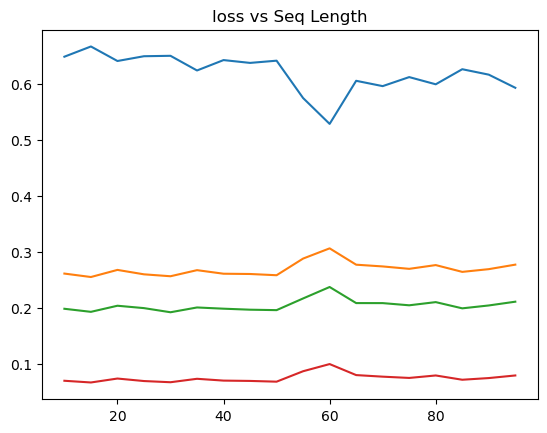

In [12]:
#plotting loss vs seq length
#plotting rmse,mae,r2,mse vs seq length


allhistory = np.array(allhistory)
plt.plot(allhistory[:,0],allhistory[:,3])
plt.plot(allhistory[:,0],allhistory[:,1])
plt.plot(allhistory[:,0],allhistory[:,2])
plt.plot(allhistory[:,0],allhistory[:,4])
plt.title('loss vs Seq Length')

In [1]:
plt.plot(allhistory[:,0],allhistory[:,4])


NameError: name 'plt' is not defined